In [1]:
%matplotlib inline
import math
import numpy as np

from scipy import integrate
from scipy import interpolate
from scipy.integrate import odeint
from scipy import optimize, exp

import matplotlib.pyplot as plt

from nbodykit.lab import *

In [2]:
cosmo = cosmology.Planck15

In [185]:
#Omega_m = cosmo.Omega0_m
#Omega_L = cosmo.Omega0_lambda
Omega_m = 0.3089
Omega_L = 0.6911

tau_array = [-0.05, -0.05, 0.1]
trace = tau_array[0] + tau_array[1] + tau_array[2]
print(trace)

a_begin = 1/(1+200)
a_end = 1.2
points = 5000

def Hubble(a):
    matter = Omega_m/a**3
    Lambda = Omega_L
    Curv = (1-Omega_m-Omega_L)/a**2
    return np.sqrt(matter+Lambda+Curv)

def dHda(a):
    up = -3*Omega_m
    down = 2*a**4*Hubble(a)
    return up/down

def dHdloga(a):
    return a*dHda(a)

def growth_int(a):
    return 1./(a*Hubble(a))**3

def growth_D(a):
    factor = 5*Omega_m*Hubble(a)/2
    return factor*integrate.quad(growth_int, 0, a)[0]

def dDda(a):
    factor = 5*Omega_m*dHda(a)/2
    second = 5*Omega_m/(2*a**3*Hubble(a)**2)
    return factor*integrate.quad(growth_int, 0, a)[0] + second

def dDdloga(a):
    return a*dDda(a)

vgrowth_D = np.vectorize(growth_D)
vdDda = np.vectorize(dDda)
vdDdloga = np.vectorize(dDdloga)

0.0


In [186]:
a_array = np.logspace(np.log(a_begin), np.log(a_end), points, base=np.exp(1))
lna_array = np.log(a_array)
a_da = np.zeros((points,6))

def Delta_f(x, lna, taux, tauy, tauz):
    ### x0 = Delta_x, x1 = Delta_x', 
    ### x2 = Delta_y, x3 = Delta_y', 
    ### x4 = Delta_z, x5 = Delta_z'
    Delta0 = 1/((1.+x[0])*(1.+x[2])*(1.+x[4]))-1.
    #Delta0 = 0
    a = np.exp(lna)
    first = 2+dHdloga(a)/Hubble(a)
    
    def tau_time(tau):
        return (tau-trace/3.)*vgrowth_D(a)/vgrowth_D(1) 
    
    const = 3*Omega_m/(2*a**3*Hubble(a)**2)
    ret = [
        x[1],
        -first*x[1] -const*(tau_time(taux)+Delta0/3.)*(1+x[0]),
        x[3],
        -first*x[3] -const*(tau_time(tauy)+Delta0/3.)*(1+x[2]),
        x[5],
        -first*x[5] -const*(tau_time(tauz)+Delta0/3.)*(1+x[4]),
    ]
    return ret

inifac = growth_D(a_array[0])/growth_D(1)
dinifac = inifac*vdDdloga(a_array[0])/growth_D(a_array[0])

Delta_ini = -np.array([tau_array[0]*inifac, tau_array[0]*dinifac,
                      tau_array[1]*inifac, tau_array[1]*dinifac,
                      tau_array[2]*inifac, tau_array[2]*dinifac])

a_da = odeint(Delta_f, Delta_ini, lna_array, args=(tau_array[0],tau_array[1],tau_array[2]))

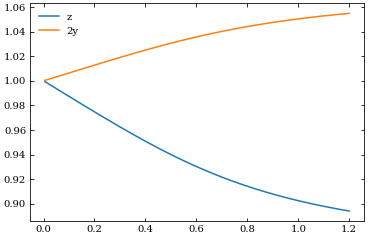

In [187]:
plt.plot(a_array,1+a_da[:,4], label='z')
plt.plot(a_array,1+a_da[:,2],label='2y')


plt.legend()
#plt.xscale('log')
#plt.plot(a_array,1+a_da[:,2])
#plt.plot(a_array,1+a_da[:,4])
#plt.plot(a_array,1-tau_array[2]*(vgrowth_D(a_array)/growth_D(1))   )

(-0.1, 0.1)

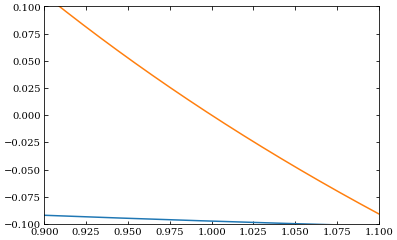

In [188]:
plt.plot(a_array,a_da[:,4], label='z')
plt.plot(a_array,(1-a_array)/a_array, label='z')
#plt.xscale('log')
plt.xlim(0.9,1.1)
plt.ylim(-0.1, 0.1)


In [189]:
delta_ax = interpolate.interp1d(a_array, a_da[:,0], kind="cubic")
delta_ay = interpolate.interp1d(a_array, a_da[:,2], kind="cubic")
delta_az = interpolate.interp1d(a_array, a_da[:,4], kind="cubic")

In [190]:
def eq(a):
    left = delta_ax(a)
    right = (1-a)/a
    return left-right

In [191]:
optimize.fsolve(eq, 1.)

array([0.95326932])

In [192]:
1+delta_ax(1.)

1.0503029325251607

In [193]:
Delta0 = 1./( (1+a_da[:,0])*(1+a_da[:,2])*(1+a_da[:,4]) ) - 1.

In [194]:
def Delta0_interp(a):
     return 1./( (1+delta_ax(a))*(1+delta_ay(a))*(1+delta_az(a)) ) - 1.

In [195]:
1+delta_ay(1)

1.0503029325251607

In [196]:
ai_save = np.zeros((points,4))
ai_save[:,0] = a_array
ai_save[:,1] = a_da[:,0]
ai_save[:,2] = a_da[:,2]
ai_save[:,3] = a_da[:,4]
print(ai_save)

[[ 4.97512438e-03  3.17182005e-04  3.17182005e-04 -6.34364010e-04]
 [ 4.98058680e-03  3.17530387e-04  3.17530387e-04 -6.35060773e-04]
 [ 4.98605522e-03  3.17879022e-04  3.17879022e-04 -6.35758042e-04]
 ...
 [ 1.19736926e+00  5.47514222e-02  5.47514222e-02 -1.05744570e-01]
 [ 1.19868391e+00  5.47765076e-02  5.47765076e-02 -1.05791266e-01]
 [ 1.20000000e+00  5.48015670e-02  5.48015670e-02 -1.05837912e-01]]


In [197]:
np.savetxt('Aniss/Aniss_planck2015_mmp01_z200_new',ai_save)

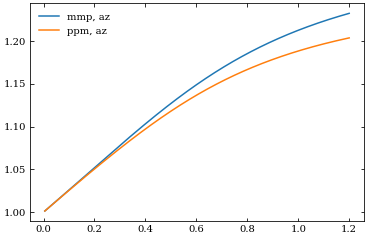

In [34]:
plt.plot(a_array,1+a_da[:,4], label='mmp, az')
plt.plot(a_array,1-ai_mmp_test[:,3],label='ppm, az')

plt.legend()


In [24]:
ai_mmp_test = ai_save

In [41]:
check_mmp = np.loadtxt('Aniss/Aniss_planck2015_ppp003_z200')
check_ppm = np.loadtxt('Aniss/Aniss_planck2015_mmm003_z200')

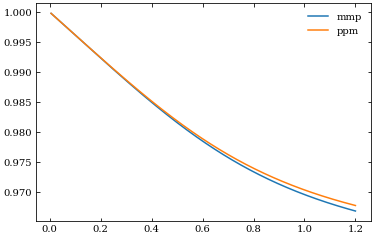

In [42]:
plt.plot(check_mmp[:,0],1+check_mmp[:,3],label='mmp')
plt.plot(check_ppm[:,0],1-check_ppm[:,3],label='ppm')
plt.legend()

In [58]:
#a_array = np.logspace(np.log(a_begin), np.log(1), points, base=np.exp(1))
#lna_array = np.log(a_array)

##pure spherical collapse eq.
a_da_iso = np.zeros((points,2))

test_db = -0.004*3

def Delta_f_iso(x, lna):
    ### x0 = Delta_a, x1 = Delta_a', 
    Delta0 = 1/((1.+x[0])*(1.+x[0])*(1.+x[0]))-1.
    #Delta0 = 0
    a = np.exp(lna)
    first = 2+dHdloga(a)/Hubble(a)
    
    const = Omega_m/(2*a**3*Hubble(a)**2)
    ret = [
        x[1],
        -first*x[1] -const*Delta0*(1+x[0]),
    ]
    return ret

#inifac = growth_D(a_array[0])/growth_D(1)
#dinifac = inifac*vdDdloga(a_array[0])/growth_D(a_array[0])

Delta_ini_iso = -np.array([test_db*inifac/3, test_db*dinifac/3])

a_da_iso = odeint(Delta_f_iso, Delta_ini_iso, lna_array)

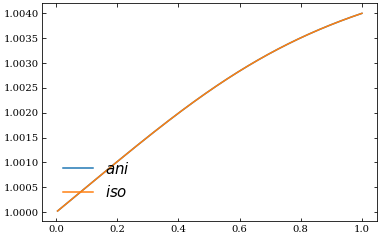

In [59]:
plt.plot(a_array,1+a_da[:,0],label=r"$ani$" )
plt.plot(a_array,1+a_da_iso[:,0],label=r"$iso$" )
#plt.plot(a_array,1+a_da[:,2])
#plt.plot(a_array,1+a_da[:,4])
#plt.plot(a_array,1-tau_array[2]*(vgrowth_D(a_array)/growth_D(1))   )
plt.legend(bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=1, fontsize=15)

In [60]:
print(a_array,a_da_iso[:,0])

[0.00497512 0.00498041 0.00498569 ... 0.9978805  0.99893969 1.        ] [2.53740271e-05 2.54009707e-05 2.54279328e-05 ... 3.99175794e-03
 3.99396652e-03 3.99617359e-03]


In [61]:
a_da_iso[-1,0]

0.0039961735862288125

In [62]:
a_array[-1]*(1+a_da_iso[-1,0])

1.0039961735862288